# 3. Detect Holo-like Conformations from an Apo Trajectory
FragBEST-Myo is a specific version of FragBEST (**Frag**ment-**B**ased protein **E**nsemble semantic **S**egmentation **T**ool). The model is trained with omecamtiv mecarbil (OM)-bound PPS/PR-state cardiac myosin trajectories. The model enables to predict the protein's surfacial region potential binding with the chemical fragments of OM. This information is further utilized for detecting holo-like conformations by converting it into holo descriptors and selecting the top-ranked conformations.  

**Here, we demonstrate how to detect and select holo-like conformations from an apo trajectory.**   

In this tutorial, you will learn:
* How to load and analyze the apo trajectory with our class objects `TrajectoryHandler`, `HoloDescriptor`, and `HoloDescriptorAnalyser`.  
* How to use parallel processing class object `TrajHandlerPreprocess` and `TrajHandlerPrediction` to work on the full trajectory.  
* How to identify the holo-like conformation from an apo trajectory.  

## Set up the environment and path

In [1]:
# only for once to append the root of the project
import os
import sys
import warnings


def find_project_root(marker=".git"):
    current_path = os.getcwd()
    while current_path != os.path.dirname(current_path):  # Stop at the filesystem root
        if marker in os.listdir(current_path):
            return current_path
        current_path = os.path.dirname(current_path)
    return None  # Return None if the marker is not found


project_root = find_project_root()
print(project_root)
# should be at the root of the project
# e.g., /.../.../.../FragBEST-Myo

# Add project_root to the Python path
sys.path.append(project_root)

# ignore warnings
warnings.filterwarnings("ignore")

/home/yuyang/Project_local/FragBEST-Myo


In [2]:
# import the necessary packages
from IPython.display import HTML, Image, display
from natsort import natsorted

from utils.datasets.general import add_prediction_to_ply, preprocess_workflow
from utils.datasets.traj_handler import TrajectoryHandler
from utils.parallel.framework import (
    TrajHandlerPrediction,
    TrajHandlerPreprocess,
    TrajHandlerVisualization,
)
from utils.ppseg.holo_descriptor.holo_descriptor import HoloDescriptorAnalyser
from utils.pymol_scripts.vis_pdb_ply import generate_pse, merge_pse


def display_df_html(df):
    """
    Display a pandas DataFrame as HTML in Jupyter Notebook.
    """
    for each in df:
        # check if the column is a list
        if isinstance(df[each].iloc[0], list):
            # convert the list to a string
            # (use two decimal places and format it as a string)
            df[each] = df[each].apply(
                lambda x: "[" + ",".join([f"{i:.2f}" for i in x]) + "]"
            )
    display(HTML('<div style="overflow-x: auto">' + df.to_html() + "</div>"))

```{attention}
It is recommended to use absolute path to indicate the file. Especially in generating the surface files.
```

## Load the inputs and create a output directory
In this tutorial, we used two input files for the apo trajectory. 
These data can be downloaded from our [Zenodo](https://doi.org/10.5281/zenodo.14945949).   
* `Apo_SMD_T300_p_fit.pdb`: the topology file.
* `Apo_SMD_200ns_skip10ns.xtc`: the trajectory file. It is a steered-MD trajecotry of cardiac myosin from post-rigor (PR) to pre-power-stroke (PPS)-like state. The simulation time is 200 ns and this trajectory is saved with 10 ns interval.  In total, there are around 20 frames.   

We also used two input files for the reference state of the cardiac myosin, which can be found in `FragBEST-Myo/dataset/ref` folder.   
* `PPS_OMB_min_cg_pl.pdb`: the reference structure to align the apo trajectory on it. Note that the reference structure is pre-power-stroke (PPS) state cardiac myosin with omecamtiv mecarbil.  
* `pocket_aux.txt`: the pocket auxiliary file generated from the reference structure.


In [3]:
# -------------- Start of user-defined variables --------------
top_path = f"{project_root}/dataset/examples/Apo_SMD_T300_p_fit.pdb"
traj_path = f"{project_root}/dataset/examples/Apo_SMD_200ns_skip10ns.xtc"

ref_path = f"{project_root}/dataset/ref/PPS_OMB_min_cg_pl.pdb"
ref_aux_path = f"{project_root}/dataset/ref/pocket_aux.txt"

output_dir = f"{project_root}/dataset/examples/outputs_holo_like"
# -------------- End of user-defined variables ----------------

# Create output directory
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Download the files from zenodo
!wget -O {top_path} https://zenodo.org/record/18630776/files/Apo_SMD_T300_p_fit.pdb
!wget -O {traj_path} https://zenodo.org/record/18630776/files/Apo_SMD_200ns_skip10ns.xtc

Now, let's load the reference structure and the apo trajectory with `TrajectoryHandler`. We also read the pocket auxiliary file (which is provided in advance) to `traj_handler`.  

Then, the apo trajectory is aligned to the reference structure by `traj_handler.aligna_traj_to_procket` with `reference=ref.universe`. This function uses the pocket residue IDs to select the atom group and align the apo trajectory to the reference structure. By default, after alignment, the pocket center is also updated based on the pocket residues. However, in this tutorial, the pocket center has already been calculated based on the reference. Thus, we set `update_pocket_center=False`.      


In [10]:
# Load reference structure
ref = TrajectoryHandler(ref_path, ligand_name="2OW", warning_check=False)

# Load trajectory
traj_handler = TrajectoryHandler(
    top_path, traj_path, ligand_name=None, warning_check=False
)

# Load the pocket aux file
traj_handler.read_pocket_aux_file(ref_aux_path)

# Align the trajectory to the reference structure
traj_handler.align_traj_to_pocket(reference=ref.universe, update_pocket_center=False)

# Print the pocket residues and the pocket center
print(f"pocket residues: {traj_handler.residues_at_pocket_str}")
print(f"pocket center: {traj_handler.pocket_center}")

pocket residues: 120 146 147 160 163 164 167 168 170 492 497 666 667 710 711 712 713 721 722 765 770 771 774
pocket center: [48.24788948519146, 107.53731136226175, 63.72042723995956]


**Note:**

The provided pocket auxiliary file was prepared from the reference structure using the following code snippet:

```python
# Obtain the pocket center from the reference structure
ref.get_pocket_center()  # Get the pocket center coordinates

# Write the pocket auxiliary file to the specified path
ref.write_pocket_aux_file(ref_aux_path)  # Save the pocket auxiliary file
```

If you are working with skeletal myosin or another isoform, the provided reference structure may not be suitable for your analysis. To deal with those cases, check the advanced usage note [here](./supplementary/fragbest_cheatsheet.md#align-the-trajectory-to-the-first-frame) to align the trajectory to the first frame.

Now, let's check the region of interest in `nglview`.   

In [ ]:
# import nglview package
# (uncomment below code to visualize the structure)

# import nglview as nv

# view = nv.show_mdanalysis(traj_handler.universe)  # visualize the structure
# view.shape.add(
#     "sphere",
#     list(traj_handler.pocket_center),
#     [0.5, 0.5, 0.5],
#     traj_handler.radius_of_interest,
#     f"region of interest with {traj_handler.radius_of_interest} angstrom radius",
# )  # the interest of region with 16.0 angstrom radius and the pocket center
# view

## Preprocess Data in Parallel  

To preprocess data in parallel, follow the steps below to generate PDB, PLY, and H5 files for each conformation.  

### 1. Initialize `TrajHandlerPreprocess`  
Use `TrajHandlerPreprocess` to manage the parallel jobs. When initializing, set the `max_workers` parameter to specify the number of threads you want to use. You can determine the optimal number of threads for your system by using tools like `htop` in your terminal.  

```{hint}
If you encounter a memory usage issue, consider reducing your `max_workers`. Setting it to `4` or `8` may resolve the problem on your machine.
```

### 2. Prepare Inputs  
Call `TrajHandlerPreprocess.prepare()` to prepare the input data.  

The trajectory will be split into multiple PDB, PLY, and H5 files. For example:  
- The PDB file for frame `0` will be saved as `/[root_path]/[filename]_0.pdb`.  
- The corresponding PLY and H5 files will be saved in the same directory with the same base filename but different extensions (`.ply` and `.h5`).  

```{important}
By using the method demonstrated here, you need to manually define the following parameters:  
  - `root_path`: The directory where the processed files will be saved.  
  - `filename`: The base name for each conformation file.  

```

If you would like to use **the configuration-based method**, `root_path` and `filename` are optional. We will demonstrate how to use a configuration-based method to run the pipeline in [advanced usage](./supplementary/fragbest_cheatsheet.md#configuration-based-method).


### 3. Run the Workflow  
For most use cases, the `preprocess_workflow` function is the main function to execute the entire preprocessing workflow. This includes:  
- Generating PDB, PLY, and H5 files.  
- Creating an index file to record the processed conformations.  

To configure the workflow, use the `TrajHandlerPreprocess.set_function()` method. This allows you to define the function and pass common arguments.  

By following these steps, you can efficiently preprocess your trajectory data in parallel, ensuring all necessary files are generated and properly organized.

In [5]:
# ----------- Start of user-defined variables ------------
logger_path = f"{output_dir}/core-dataprep-info.log"
max_workers = 24
filename_p = "Apo_SMD_protein"  # filename base for each conformation
# ----------- End of user-defined variables --------------

# Prepare to run the dataset preprocessing
p_jobs = TrajHandlerPreprocess(max_workers=max_workers, logger_path=logger_path)
p_jobs.prepare(
    traj_handler,
    root_path=output_dir,
    filename=filename_p,
)

# set the function
p_jobs.set_function(preprocess_workflow)

# run the preprocessing workflow
p_jobs.run()  # this takes around 3.5 minutes

2025-12-11 16:58:48,318 core-dataprep INFO: Preprocess: 10 done
2025-12-11 16:58:58,673 core-dataprep INFO: Preprocess: 16 done
2025-12-11 16:59:12,120 core-dataprep INFO: Preprocess: 8 done
2025-12-11 16:59:12,314 core-dataprep INFO: Preprocess: 11 done
2025-12-11 16:59:23,970 core-dataprep INFO: Preprocess: 13 done
2025-12-11 16:59:24,566 core-dataprep INFO: Preprocess: 12 done
2025-12-11 16:59:27,077 core-dataprep INFO: Preprocess: 1 done
2025-12-11 16:59:28,306 core-dataprep INFO: Preprocess: 4 done
2025-12-11 16:59:34,172 core-dataprep INFO: Preprocess: 3 done
2025-12-11 16:59:35,877 core-dataprep INFO: Preprocess: 6 done
2025-12-11 16:59:36,786 core-dataprep INFO: Preprocess: 7 done
2025-12-11 16:59:38,058 core-dataprep INFO: Preprocess: 9 done
2025-12-11 16:59:38,475 core-dataprep INFO: Preprocess: 0 done
2025-12-11 16:59:42,342 core-dataprep INFO: Preprocess: 17 done
2025-12-11 16:59:47,649 core-dataprep INFO: Preprocess: 14 done
2025-12-11 16:59:48,109 core-dataprep INFO: Prep

**Now, you have completed the preprocess of the data.**  


Some optional parameters can be adjusted, check [here](./supplementary/fragbest_cheatsheet.md#optional-parameters-for-input-preparation) for more details.

## Make Predictions in Parallel   

Similar to data preprocessing, predictions can also be performed using parallel processors for increased efficiency.  

Here, we use `TrajHandlerPrediction` instead of `TrajHandlerPreprocess`. The `TrajHandlerPrediction` class inherits most attributes from `TrajHandlerPreprocess` but includes minor modifications. Additionally, we utilize the `add_prediction_to_ply` function to make predictions.  

**Preparation Steps**  
Similar to the preprocessing step, you need to define the following:  
- `root_path`: The root directory containing the trajectory files.  
- `filename`: The name of the file(s) to process.  

When running the function, you’ll also need to include the following parameters:    
- `model_path`: Path to the pretrained model checkpoint used for making predictions.  


In [6]:
# ----------- Start of user-defined variables ------------
logger_path = f"{output_dir}/core-predict-info.log"
max_workers = 16
filename_p = "Apo_SMD_protein"  # filename base for each conformation
model_path = f"{project_root}/utils/ppseg/myo/Kfold2_best_model_169_miou=0.7525.pt"
# ----------- End of user-defined variables --------------

# Prepare to run the dataset preprocessing
p_jobs = TrajHandlerPrediction(max_workers=max_workers, logger_path=logger_path)
p_jobs.prepare(traj_handler, root_path=output_dir, filename=filename_p)

# set up the function
p_jobs.set_function(
    func=add_prediction_to_ply,
    model_path=model_path,
)

# run the preprocessing workflow
p_jobs.run()  # this takes around 1 minute"

2025-12-11 17:00:13,225 core-predict INFO: Prediction: 11 done
2025-12-11 17:00:13,876 core-predict INFO: Prediction: 10 done
2025-12-11 17:00:14,132 core-predict INFO: Prediction: 8 done
2025-12-11 17:00:15,684 core-predict INFO: Prediction: 6 done
2025-12-11 17:00:15,861 core-predict INFO: Prediction: 14 done
2025-12-11 17:00:17,698 core-predict INFO: Prediction: 2 done
2025-12-11 17:00:18,151 core-predict INFO: Prediction: 3 done
2025-12-11 17:00:18,846 core-predict INFO: Prediction: 0 done
2025-12-11 17:00:19,120 core-predict INFO: Prediction: 12 done
2025-12-11 17:00:19,214 core-predict INFO: Prediction: 5 done
2025-12-11 17:00:19,610 core-predict INFO: Prediction: 4 done
2025-12-11 17:00:19,731 core-predict INFO: Prediction: 1 done
2025-12-11 17:00:19,788 core-predict INFO: Prediction: 13 done
2025-12-11 17:00:20,868 core-predict INFO: Prediction: 15 done
2025-12-11 17:00:20,945 core-predict INFO: Prediction: 9 done
2025-12-11 17:00:20,952 core-predict INFO: Prediction: 7 done
20

In default, `cpu` is used for the prediction. If you wish to use `cuda` for prediction, check the optional parameters for prediction [here](./supplementary/fragbest_cheatsheet.md#optional-parameters-for-prediction) for more details. 

```{important}
We expect your GPU is compatible with CUDA 12. If FragBEST-Myo doesn't work with GPU, please use cpu instead.
```

## Analyze the Results

To analyze the results, we use the `HoloDescriptorAnalyser`. Since FragBEST-Myo was trained with predefined fragments (see the figure), the corresponding fragment information was prepared beforehand. This information is also available in the example file located at `FragBEST-Myo/utils/ppseg/myo/ligand_fragments_example.json` (loaded by default).

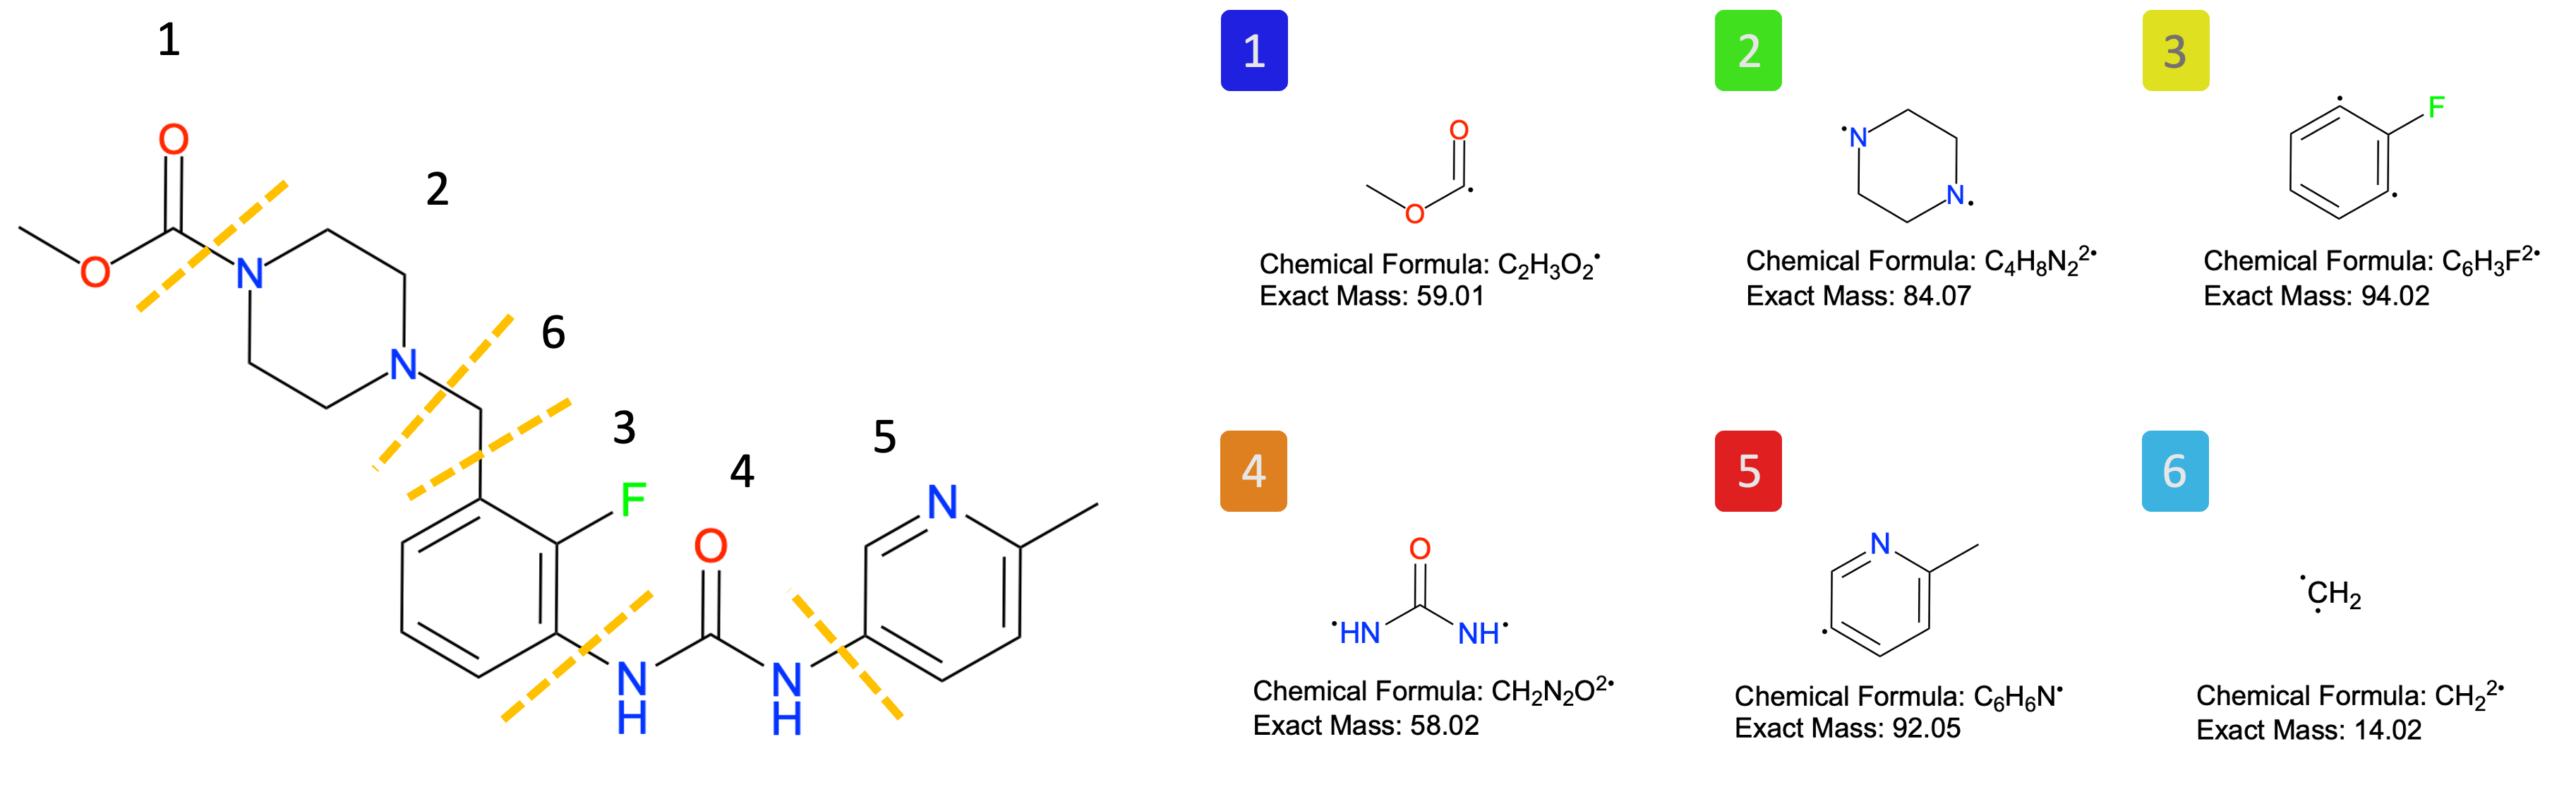

In [7]:
# visualization of fragments
Image(filename=f"{project_root}/imgs/OM_fragment.png")


The `source_path` parameter should point to the directory where you have saved the required files (JSON). After setting up the paths, follow these steps:

1. **List the files**: Use `self.list_files()` to generate a list of relevant files.
2. **Read the files**: Load the files and enable HoloSpace calculation by using `self.read(holospace_calc=True)`.
3. **Perform z-score normalization**: Normalize the data with `self.calculate_zscore()` using the following four recommended descriptors:  
   - `num_of_classes` (D<sub>1</sub>)
   - `nonbck_ratio` (D<sub>2</sub>)
   - `nonbck_class_pt_ratio` (D<sub>3</sub>)
   - `holospace_frag_score` (D<sub>4</sub>)
4. **Set the rank**: Rank the results using `self.set_rank()` with equal weights (default setting) and prioritize the conformations without warnings by setting `filter_warning=True`.   
5. **Select top N results**: Select top N conformations using `self.set_n()`.  

For further details about `HoloDescriptor`, refer to the [Tutorial 2](./02_analyze_PDB_from_RCSB.ipynb).

In [8]:
# source_path having the holo-descriptor json files
hd_analyser = HoloDescriptorAnalyser(source_path=output_dir)

# list the files
hd_analyser.list_files()

# read the multiple holo descriptor files
hd_analyser.read(holospace_calc=True)

# calculate the z-score of the selected holo descriptors (without preset)
hd_analyser.calculate_zscore("num_of_classes")
hd_analyser.calculate_zscore("nonbck_ratio")
hd_analyser.calculate_zscore("nonbck_class_pt_ratio")
hd_analyser.calculate_zscore("holospace_frag_score")

# set the rank
hd_analyser.set_rank(filter_warning=True)

Found 21 files


In total, 21 files are expected to be found (21 different conformations). With the `filter_warning`, the conformations that produce warnings will be assigned a lower rank.

In [9]:
# display top 5 conformations
display_df_html(hd_analyser.top_n(5))

,class_predprobs,overall_predprobs,class_pt_ratio,nonbck_ratio,nonbck_class_pt_ratio,num_of_classes,num_interest_points,holospace_volume,holospace_frag_volumes,filename,warnings,holospace_frag_score,num_of_classes_zscore,nonbck_ratio_zscore,nonbck_class_pt_ratio_zscore,holospace_frag_score_zscore,overall_score,rank
18,"[0.99,0.79,0.95,0.95,0.96,0.95,0.98]",0.985760,"[0.82,0.00,0.05,0.03,0.05,0.04,0.01]",0.177013,0.029502,7,1192,1425.133093,"[16.20,328.51,424.08,269.75,287.77,0.43]",Apo_SMD_protein_18.json,,0.718336,0.599760,0.676221,0.460933,-0.008688,0.432057,1
19,"[1.00,0.94,0.98,0.95,0.97,0.94,0.94]",0.989418,"[0.83,0.01,0.03,0.03,0.03,0.04,0.01]",0.165821,0.027637,7,1182,1178.433980,"[14.47,108.67,265.54,300.95,383.91,10.49]",Apo_SMD_protein_19.json,,0.781809,0.599760,0.418171,0.161502,0.374824,0.388565,2
17,"[1.00,0.96,0.92,0.96,0.93,0.93,0.97]",0.986726,"[0.86,0.01,0.01,0.02,0.05,0.05,0.01]",0.143145,0.023858,7,992,1269.889447,"[44.57,32.80,235.56,372.77,550.25,23.52]",Apo_SMD_protein_17.json,,0.856523,0.599760,-0.104612,-0.445115,0.826254,0.219072,3
16,"[0.99,0.77,0.97,0.96,0.95,0.95,0.83]",0.985944,"[0.87,0.00,0.03,0.03,0.03,0.04,0.01]",0.134799,0.022467,7,1046,1307.407488,"[13.07,86.27,310.94,260.63,552.91,45.98]",Apo_SMD_protein_16.json,,0.868869,0.599760,-0.297028,-0.668386,0.900846,0.133798,4
11,"[0.99,0.00,0.94,0.90,0.94,0.00,0.71]",0.986498,"[0.92,0.00,0.01,0.02,0.04,0.00,0.00]",0.079692,0.019923,5,1167,565.385082,"[0.00,59.90,67.75,436.31,0.00,1.42]",Apo_SMD_protein_11.json,,0.422911,-1.919232,-1.567538,-1.076676,-1.79368,-1.589282,5


From the results, **4 conformations were identified without warnings**. By rank, these correspond to frames `19`, `18`, `15`, and `11`, which represent time points `190 ns`, `180 ns`, `150 ns`, and `110 ns`, respectively.  

**Key Insight:**  
- **Higher-ranked conformations** (e.g., frame `19` > `18` > `15` > `11`) have a **higher probability of being holo-like conformations**.  
- These conformations are considered **valuable protein ensembles** and can be selected for further drug design studies.  

By prioritizing these frames, you can focus on structures most likely to contribute to effective drug discovery.

## Visualization  

For visualizing individual structures, you can use **PyMOL** to open the **PLY file** with our plugin: [FragBEST PyMOL Plugin](https://github.com/fornililab/FragBEST_pymol_plugin). This plugin enables detailed visualization of features, labels, and predicted points on the protein surface.  

Alternatively, refer to **[Tutorial 1 - Visualization with PyMOL](./01_trajectory_handler.ipynb#visualization-with-pymol)** to learn how to generate `.pse` visualization files with the code.  

**Batch Visualization with Parallel Processing**  
You can also use a **parallel processor** to generate `.pse` files for multiple structures simultaneously. After generating individual visualization files, you can **merge all the `.pse` files** into a single `.pse` file for comprehensive visualization.  

This approach simplifies the visualization process for large protein ensembles and provides an efficient way to analyze multiple structures in one view.

### Step 1: Set Up a Parallel Processor to Generate Multiple Files  
Similar to preprocessing and prediction, you need to configure the following: **logger**, **max_workers**, and **filename_p** (the base name for the protein files). The executable **PyMOL** is already installed as part of the environment setup.

In [10]:
# ----------- Start of user-defined variables ------------
logger_path = f"{output_dir}/core-vis-info.log"
max_workers = 24
filename_p = "Apo_SMD_protein"  # filename base for each conformation
# ----------- End of user-defined variables --------------

# Set up the pymol path
pymol_path = !pixi run -e pymol which pymol
pymol_path = pymol_path[0]

# Prepare to run the dataset preprocessing
p_jobs = TrajHandlerVisualization(max_workers=max_workers, logger_path=logger_path)
p_jobs.prepare(
    traj_handler,
    root_path=output_dir,
    filename=filename_p,
)

# set the function
p_jobs.set_function(generate_pse, pymol_path=pymol_path)

# run the preprocessing workflow
p_jobs.run()  # this takes around 3 minutes

interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:26,979 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_17.pse


pb_vert_Apo_SMD_protein_17.ply pb_surf_Apo_SMD_protein_17.ply hphob_vert_Apo_SMD_protein_17.ply hphob_surf_Apo_SMD_protein_17.ply hbond_vert_Apo_SMD_protein_17.ply hbond_surf_Apo_SMD_protein_17.ply pred_vert_Apo_SMD_protein_17.ply pred_surf_Apo_SMD_protein_17.ply mesh_Apo_SMD_protein_17.ply
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:32,244 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_16.pse


pb_vert_Apo_SMD_protein_16.ply pb_surf_Apo_SMD_protein_16.ply hphob_vert_Apo_SMD_protein_16.ply hphob_surf_Apo_SMD_protein_16.ply hbond_vert_Apo_SMD_protein_16.ply hbond_surf_Apo_SMD_protein_16.ply pred_vert_Apo_SMD_protein_16.ply pred_surf_Apo_SMD_protein_16.ply mesh_Apo_SMD_protein_16.ply
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:37,331 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_14.pse


pb_vert_Apo_SMD_protein_14.ply pb_surf_Apo_SMD_protein_14.ply hphob_vert_Apo_SMD_protein_14.ply hphob_surf_Apo_SMD_protein_14.ply hbond_vert_Apo_SMD_protein_14.ply hbond_surf_Apo_SMD_protein_14.ply pred_vert_Apo_SMD_protein_14.ply pred_surf_Apo_SMD_protein_14.ply mesh_Apo_SMD_protein_14.ply
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:38,321 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_0.pse


pb_vert_Apo_SMD_protein_0.ply pb_surf_Apo_SMD_protein_0.ply hphob_vert_Apo_SMD_protein_0.ply hphob_surf_Apo_SMD_protein_0.ply hbond_vert_Apo_SMD_protein_0.ply hbond_surf_Apo_SMD_protein_0.ply pred_vert_Apo_SMD_protein_0.ply pred_surf_Apo_SMD_protein_0.ply mesh_Apo_SMD_protein_0.ply
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:41,070 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_15.pse


pb_vert_Apo_SMD_protein_15.ply pb_surf_Apo_SMD_protein_15.ply hphob_vert_Apo_SMD_protein_15.ply hphob_surf_Apo_SMD_protein_15.ply hbond_vert_Apo_SMD_protein_15.ply hbond_surf_Apo_SMD_protein_15.ply pred_vert_Apo_SMD_protein_15.ply pred_surf_Apo_SMD_protein_15.ply mesh_Apo_SMD_protein_15.ply
interest_pt: 1
ignore_surface: 0
interest_pt: 1
ignore_surface: 0
pb_vert_Apo_SMD_protein_1.ply pb_surf_Apo_SMD_protein_1.ply hphob_vert_Apo_SMD_protein_1.ply hphob_surf_Apo_SMD_protein_1.ply hbond_vert_Apo_SMD_protein_1.ply hbond_surf_Apo_SMD_protein_1.ply pred_vert_Apo_SMD_protein_1.ply pred_surf_Apo_SMD_protein_1.ply mesh_Apo_SMD_protein_1.ply


2025-12-11 17:03:45,464 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_1.pse
2025-12-11 17:03:45,796 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_4.pse


pb_vert_Apo_SMD_protein_4.ply pb_surf_Apo_SMD_protein_4.ply hphob_vert_Apo_SMD_protein_4.ply hphob_surf_Apo_SMD_protein_4.ply hbond_vert_Apo_SMD_protein_4.ply hbond_surf_Apo_SMD_protein_4.ply pred_vert_Apo_SMD_protein_4.ply pred_surf_Apo_SMD_protein_4.ply mesh_Apo_SMD_protein_4.ply
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:47,019 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_10.pse


pb_vert_Apo_SMD_protein_10.ply pb_surf_Apo_SMD_protein_10.ply hphob_vert_Apo_SMD_protein_10.ply hphob_surf_Apo_SMD_protein_10.ply hbond_vert_Apo_SMD_protein_10.ply hbond_surf_Apo_SMD_protein_10.ply pred_vert_Apo_SMD_protein_10.ply pred_surf_Apo_SMD_protein_10.ply mesh_Apo_SMD_protein_10.ply
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:48,265 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_19.pse


pb_vert_Apo_SMD_protein_19.ply pb_surf_Apo_SMD_protein_19.ply hphob_vert_Apo_SMD_protein_19.ply hphob_surf_Apo_SMD_protein_19.ply hbond_vert_Apo_SMD_protein_19.ply hbond_surf_Apo_SMD_protein_19.ply pred_vert_Apo_SMD_protein_19.ply pred_surf_Apo_SMD_protein_19.ply mesh_Apo_SMD_protein_19.ply
interest_pt: 1
ignore_surface: 0
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:48,861 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_2.pse
2025-12-11 17:03:48,887 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_9.pse


pb_vert_Apo_SMD_protein_2.ply pb_surf_Apo_SMD_protein_2.ply hphob_vert_Apo_SMD_protein_2.ply hphob_surf_Apo_SMD_protein_2.ply hbond_vert_Apo_SMD_protein_2.ply hbond_surf_Apo_SMD_protein_2.ply pred_vert_Apo_SMD_protein_2.ply pred_surf_Apo_SMD_protein_2.ply mesh_Apo_SMD_protein_2.ply
pb_vert_Apo_SMD_protein_9.ply pb_surf_Apo_SMD_protein_9.ply hphob_vert_Apo_SMD_protein_9.ply hphob_surf_Apo_SMD_protein_9.ply hbond_vert_Apo_SMD_protein_9.ply hbond_surf_Apo_SMD_protein_9.ply pred_vert_Apo_SMD_protein_9.ply pred_surf_Apo_SMD_protein_9.ply mesh_Apo_SMD_protein_9.ply
interest_pt: 1
ignore_surface: 0
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:49,699 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_8.pse


pb_vert_Apo_SMD_protein_8.ply pb_surf_Apo_SMD_protein_8.ply hphob_vert_Apo_SMD_protein_8.ply hphob_surf_Apo_SMD_protein_8.ply hbond_vert_Apo_SMD_protein_8.ply hbond_surf_Apo_SMD_protein_8.ply pred_vert_Apo_SMD_protein_8.ply pred_surf_Apo_SMD_protein_8.ply mesh_Apo_SMD_protein_8.ply
pb_vert_Apo_SMD_protein_3.ply pb_surf_Apo_SMD_protein_3.ply hphob_vert_Apo_SMD_protein_3.ply hphob_surf_Apo_SMD_protein_3.ply hbond_vert_Apo_SMD_protein_3.ply hbond_surf_Apo_SMD_protein_3.ply pred_vert_Apo_SMD_protein_3.ply pred_surf_Apo_SMD_protein_3.ply mesh_Apo_SMD_protein_3.ply


2025-12-11 17:03:49,846 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_3.pse


interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:51,815 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_18.pse


pb_vert_Apo_SMD_protein_18.ply pb_surf_Apo_SMD_protein_18.ply hphob_vert_Apo_SMD_protein_18.ply hphob_surf_Apo_SMD_protein_18.ply hbond_vert_Apo_SMD_protein_18.ply hbond_surf_Apo_SMD_protein_18.ply pred_vert_Apo_SMD_protein_18.ply pred_surf_Apo_SMD_protein_18.ply mesh_Apo_SMD_protein_18.ply
interest_pt: 1
ignore_surface: 0
interest_pt: 1
ignore_surface: 0
pb_vert_Apo_SMD_protein_13.ply pb_surf_Apo_SMD_protein_13.ply hphob_vert_Apo_SMD_protein_13.ply hphob_surf_Apo_SMD_protein_13.ply hbond_vert_Apo_SMD_protein_13.ply hbond_surf_Apo_SMD_protein_13.ply pred_vert_Apo_SMD_protein_13.ply pred_surf_Apo_SMD_protein_13.ply mesh_Apo_SMD_protein_13.ply


2025-12-11 17:03:53,518 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_13.pse
2025-12-11 17:03:53,762 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_5.pse


pb_vert_Apo_SMD_protein_5.ply pb_surf_Apo_SMD_protein_5.ply hphob_vert_Apo_SMD_protein_5.ply hphob_surf_Apo_SMD_protein_5.ply hbond_vert_Apo_SMD_protein_5.ply hbond_surf_Apo_SMD_protein_5.ply pred_vert_Apo_SMD_protein_5.ply pred_surf_Apo_SMD_protein_5.ply mesh_Apo_SMD_protein_5.ply
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:54,470 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_6.pse


interest_pt: 1
ignore_surface: 0
interest_pt: 1
ignore_surface: 0
pb_vert_Apo_SMD_protein_6.ply pb_surf_Apo_SMD_protein_6.ply hphob_vert_Apo_SMD_protein_6.ply hphob_surf_Apo_SMD_protein_6.ply hbond_vert_Apo_SMD_protein_6.ply hbond_surf_Apo_SMD_protein_6.ply pred_vert_Apo_SMD_protein_6.ply pred_surf_Apo_SMD_protein_6.ply mesh_Apo_SMD_protein_6.ply
interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:54,841 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_20.pse
2025-12-11 17:03:54,822 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_7.pse


pb_vert_Apo_SMD_protein_7.ply pb_surf_Apo_SMD_protein_7.ply hphob_vert_Apo_SMD_protein_7.ply hphob_surf_Apo_SMD_protein_7.ply hbond_vert_Apo_SMD_protein_7.ply hbond_surf_Apo_SMD_protein_7.ply pred_vert_Apo_SMD_protein_7.ply pred_surf_Apo_SMD_protein_7.ply mesh_Apo_SMD_protein_7.ply
pb_vert_Apo_SMD_protein_20.ply pb_surf_Apo_SMD_protein_20.ply hphob_vert_Apo_SMD_protein_20.ply hphob_surf_Apo_SMD_protein_20.ply hbond_vert_Apo_SMD_protein_20.ply hbond_surf_Apo_SMD_protein_20.ply pred_vert_Apo_SMD_protein_20.ply pred_surf_Apo_SMD_protein_20.ply mesh_Apo_SMD_protein_20.ply
pb_vert_Apo_SMD_protein_11.ply pb_surf_Apo_SMD_protein_11.ply hphob_vert_Apo_SMD_protein_11.ply hphob_surf_Apo_SMD_protein_11.ply hbond_vert_Apo_SMD_protein_11.ply hbond_surf_Apo_SMD_protein_11.ply pred_vert_Apo_SMD_protein_11.ply pred_surf_Apo_SMD_protein_11.ply mesh_Apo_SMD_protein_11.ply


2025-12-11 17:03:55,032 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_11.pse


interest_pt: 1
ignore_surface: 0


2025-12-11 17:03:56,757 core-vis INFO: Generated PyMOL session file: Apo_SMD_protein_12.pse


pb_vert_Apo_SMD_protein_12.ply pb_surf_Apo_SMD_protein_12.ply hphob_vert_Apo_SMD_protein_12.ply hphob_surf_Apo_SMD_protein_12.ply hbond_vert_Apo_SMD_protein_12.ply hbond_surf_Apo_SMD_protein_12.ply pred_vert_Apo_SMD_protein_12.ply pred_surf_Apo_SMD_protein_12.ply mesh_Apo_SMD_protein_12.ply


### Step 2: Merge the Files
This step involves merging multiple `.pse` files into a single file, allowing you to load all the structures at once instead of loading each file manually in PyMOL.

In [11]:
# ----------- Start of user-defined variables ------------
pse_output_path = f"{output_dir}/Apo_SMD_protein_vis_all.pse"
# ----------- End of user-defined variables --------------

# Set up pymol path
pymol_path = !pixi run -e pymol which pymol
pymol_path = pymol_path[0]

# Merge the .pse files
pse_file_list = natsorted(
    [each for each in os.listdir(output_dir) if each.endswith(".pse")]
)
pse_file_list = [os.path.join(output_dir, each) for each in pse_file_list]
merge_pse(
    pse_file_list=pse_file_list,
    merged_pse_output=pse_output_path,
    pymol_path=pymol_path,
)  # this takes around 15 seconds

The visualization allows you to analyze the predictions across different frames of a protein ensemble. If it is an MD (Molecular Dynamics) trajectory, this visualization helps you understand how the structures—and specifically the fragment-binding regions—change over time.  

In the example below, the visualization of the protein surface spans from the **first frame** to the **last frame** of the apo SMD trajectory, with an interval of **10 ns**.  

You may notice significant differences in the protein surfaces between:  
- The **first frame**, where the surface is colored by predicted fragment-binding regions.  
- The **last frame**, where the mesh and vertices are colored by predicted fragment-binding regions.  

This comparison highlights how the protein surface and binding regions evolve throughout the trajectory.

Check the data (`Apo_SMD_protein_vis_all.pse`) by yourself in PyMOL if you are interested in the details. 

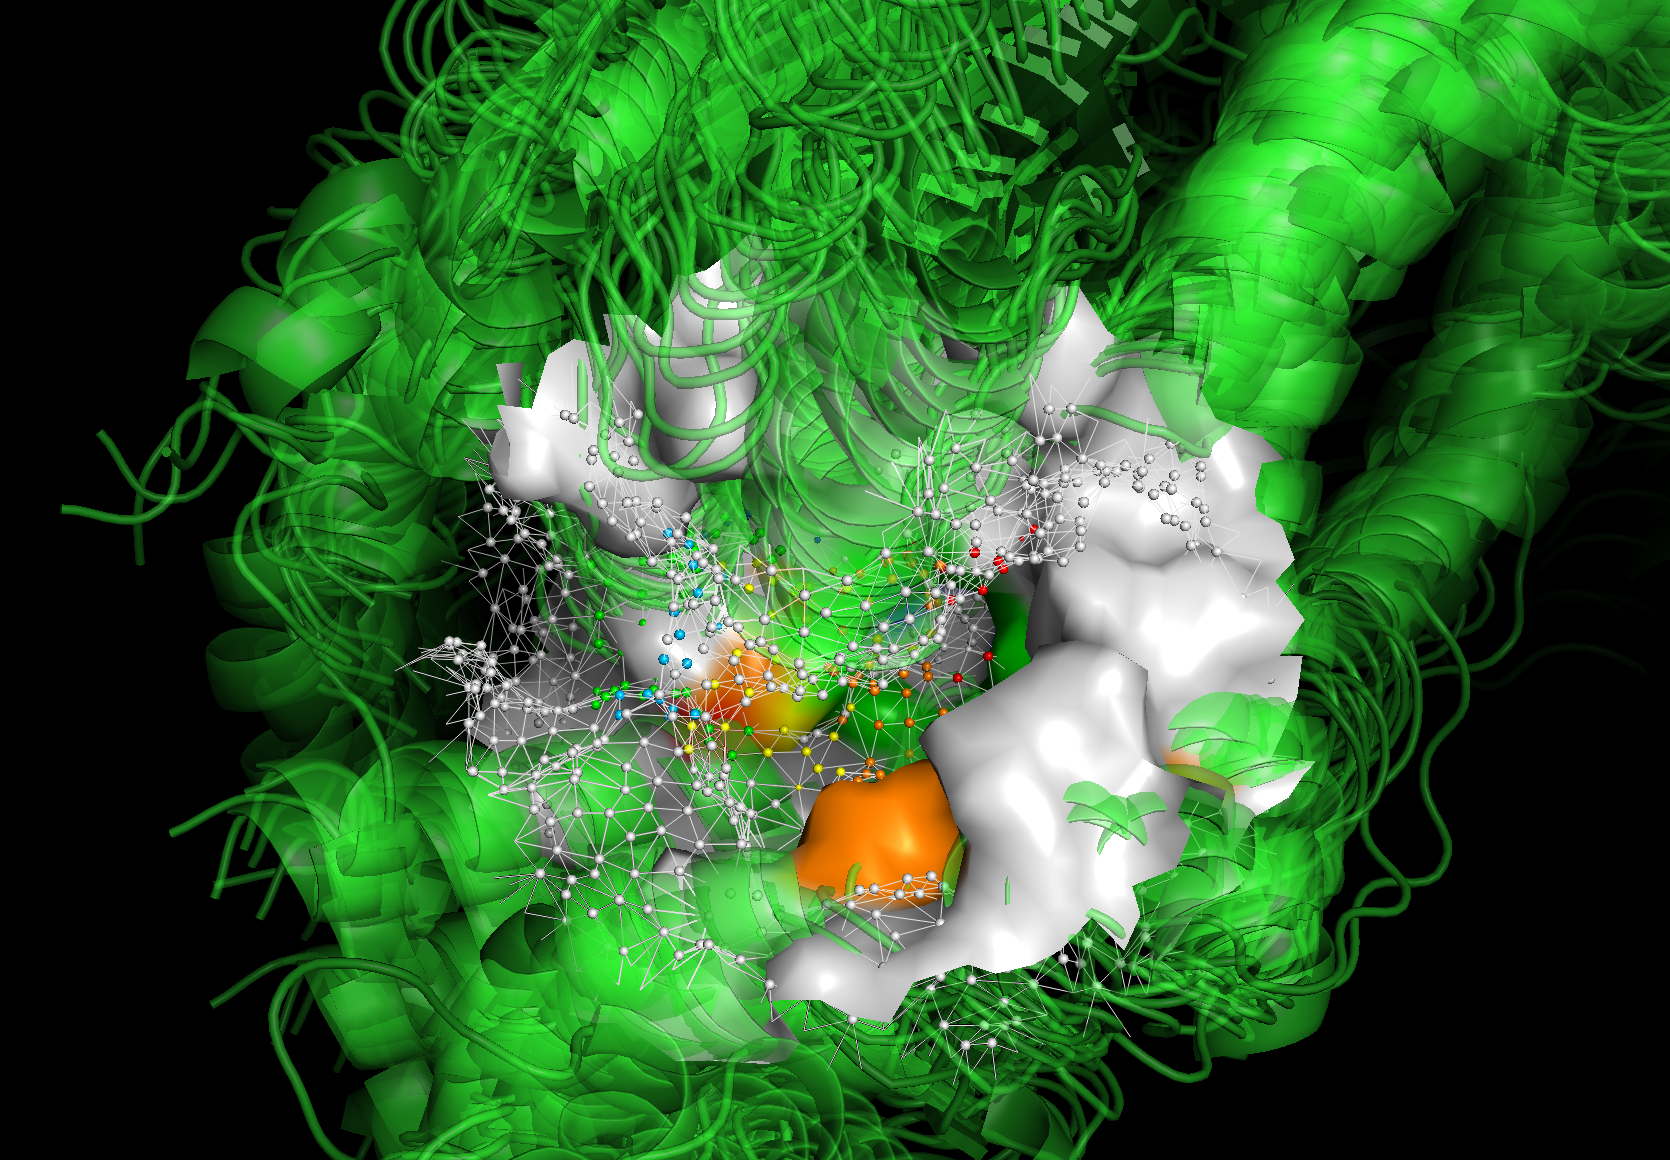

In [12]:
# Here is a screenshot for the pymol visualization.
Image(filename=f"{project_root}/imgs/pymol_vis_02.png")

## Conclusion  
Congratulations! You have now completed the tutorial. Here's what you've achieved:  

- **Loaded and Analyzed the Apo Trajectory**  
  - Used `TrajectoryHandler` and `HoloDescriptorAnalyser` to load and analyze the apo trajectory.  

- **Used Parallel Processing for Efficiency**  
  - Leveraged parallel processing using `TrajHandlerPreprocess` and `TrajHandlerPrediction` to process the full trajectory efficiently.  

- **Identified Holo-like Conformations**  
  - Successfully identified holo-like conformations from an apo trajectory, which can serve as valuable protein ensembles for further drug design.  

### Next Steps  
This concludes all three tutorials. If you have any questions or encounter any issues, feel free to raise them on the [GitHub repository](https://github.com/fornililab/FragBEST-Myo).  

Good luck with your research, and happy analyzing! 🚀